# Imports

In [1]:
import torch
import matplotlib.pyplot as plt
import random
from torchvision import datasets, transforms

In [ ]:
from lstm import LSTM
from ddpm import UNET, inference
from grayscott import GrayScott, laplacian
from training import train_lstm, train_ddpm
from analyzer import Analyzer
from constants import *

# Device

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## LSTM Dataset

In [4]:
def create_sine_dataset(samples=100, seq_len=50):
    data = []
    for _ in range(samples):
        # Random frequency and phase to make it robust
        freq = np.random.uniform(0.5, 2.0)
        phase = np.random.uniform(0, 2*np.pi)
        t = np.linspace(0, 10, seq_len)
        
        # Signal = Sine + slight noise
        signal = np.sin(freq * t + phase) + 0.05 * np.random.randn(seq_len)
        data.append(signal)
    
    # Shape: [Batch, Seq_Len, Input_Size=1]
    return torch.FloatTensor(np.array(data)).unsqueeze(2)

# def create_shapes_dataset(samples=100, size=32):
#     data = []
#     for _ in range(samples):
#         img = np.zeros((size, size))
        
#         # Random Square
#         x = np.random.randint(5, size-10)
#         y = np.random.randint(5, size-10)
#         w = np.random.randint(5, 10)
#         img[x:x+w, y:y+w] = 1.0
        
#         data.append(img)
        
#     # Shape: [Batch, Channels=1, Height, Width]
#     return torch.FloatTensor(np.array(data)).unsqueeze(1)

In [5]:
samples = create_sine_dataset(100,50)
samples.size()

torch.Size([100, 50, 1])

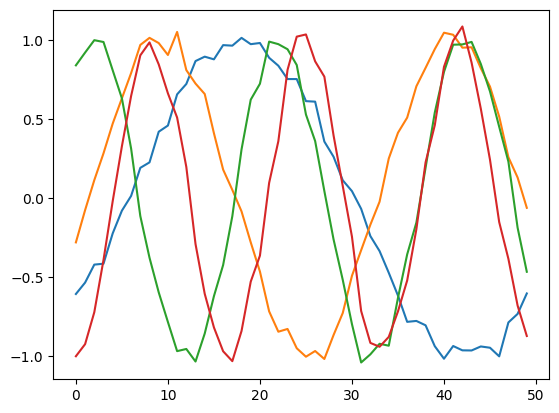

In [6]:
for _ in range(4):
    rand_index = random.randint(0, 100)
    plt.plot(samples[rand_index,:,0])

# LSTM Training

In [7]:
n_samples = 1000
seq_len = 50
n_epochs = 200

In [8]:
lstm_data = create_sine_dataset(samples=n_samples, seq_len=seq_len)
lstm_data = lstm_data.to(device)

lstm_model = LSTM(input_size=1, hidden_size=16).to(device)

--- Training LSTM on cpu ---
Epoch 0: Loss 0.39745
Epoch 10: Loss 0.10907
Epoch 20: Loss 0.04274
Epoch 30: Loss 0.02941
Epoch 40: Loss 0.02140
Epoch 50: Loss 0.01841
Epoch 60: Loss 0.01594
Epoch 70: Loss 0.01439
Epoch 80: Loss 0.01323
Epoch 90: Loss 0.01233
Epoch 100: Loss 0.01165
Epoch 110: Loss 0.01111
Epoch 120: Loss 0.01068
Epoch 130: Loss 0.01032
Epoch 140: Loss 0.01001
Epoch 150: Loss 0.00974
Epoch 160: Loss 0.00950
Epoch 170: Loss 0.00929
Epoch 180: Loss 0.00910
Epoch 190: Loss 0.00893


Text(0.5, 0, 'epoch')

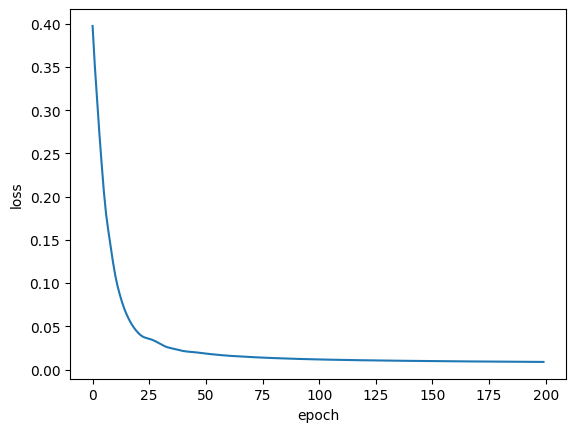

In [9]:
loss_lstm = train_lstm(lstm_model, lstm_data, num_epochs=n_epochs, lr=1e-2, device=device)

plt.plot(loss_lstm)
plt.ylabel("loss")
plt.xlabel("epoch")

Seed shape: torch.Size([50, 1])
Seed values: tensor([[0.0230],
        [0.3844],
        [0.6485],
        [0.9491],
        [0.9960]])
Generated shape: torch.Size([100, 1])
Generated values: tensor([[0.1045],
        [0.1570],
        [0.2354],
        [0.2454],
        [0.1737]])


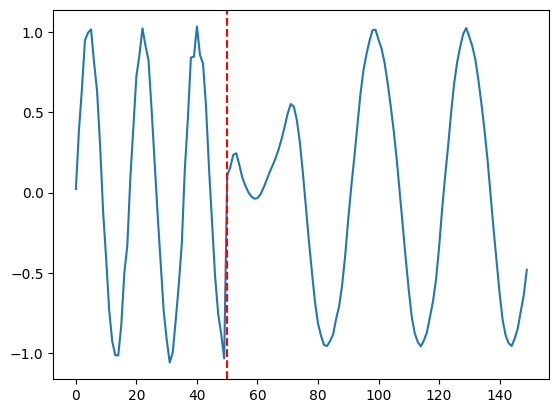

In [52]:
rand_index = random.randint(0, n_samples)
seed_sample = lstm_data[rand_index]

future_steps = 2*seq_len
generated, history_generated = lstm_model.generate_sequence(seed_sample, future_steps=future_steps)

print(f"Seed shape: {seed_sample.shape}")
print(f"Seed values: {seed_sample[:5]}")
print(f"Generated shape: {generated.shape}")
print(f"Generated values: {generated[:5]}")

plt.plot(torch.cat((seed_sample.to("cpu"), generated.to("cpu"))))
plt.axvline(x=seq_len, color='red', linestyle='--')

# LSTM Visualization

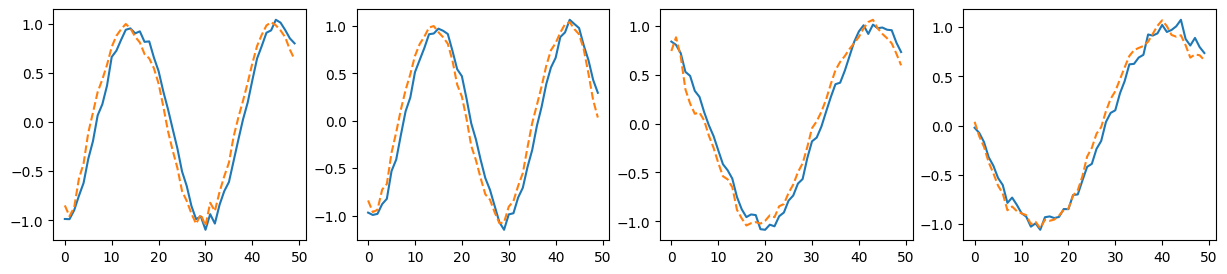

In [11]:
lstm_out, history_lstm = lstm_model(lstm_data)
fig, ax = plt.subplots(1,4, figsize=(15,3))
for i in range(4):
    rand_index = random.randint(0,n_samples)
    ax[i].plot(lstm_data[rand_index,:,0].to("cpu").detach().numpy(), label="true data")
    ax[i].plot(lstm_out[rand_index,:,0].to("cpu").detach().numpy(), linestyle="--", label="lstm output")

plt.show()

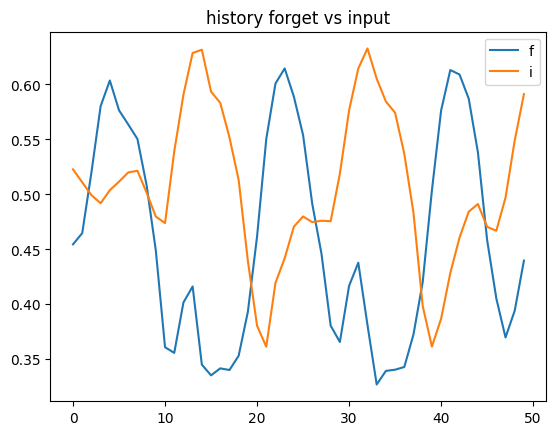

In [12]:
rand_index = random.randint(0,n_samples)
forget = [[t[rand_index, d].item() for t in history_lstm["forget"]] for d in range(16)]
input = [[t[rand_index, d].item() for t in history_lstm["input"]] for d in range(16)]

def mean_forget(forget):
    l = []
    s = 0
    for j in range(seq_len):
        for i in range(16):
            s += forget[i][j]
        l.append(s/16)
        s=0
    return l
forget_mean = mean_forget(forget)
input_mean = mean_forget(input)
plt.plot(forget_mean, label="f")
plt.plot(input_mean, label="i")
plt.title("history forget vs input")
plt.legend()
plt.show()

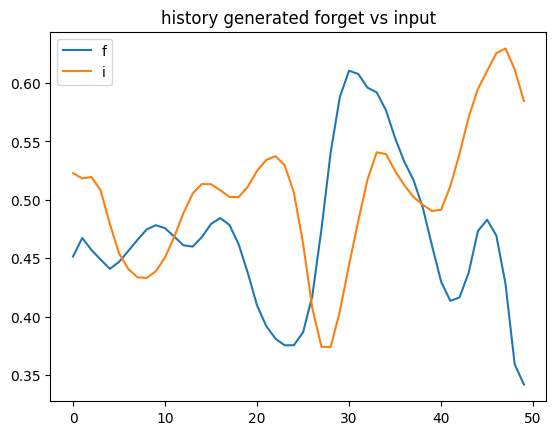

In [53]:
forget = [[t[0, d].item() for t in history_generated["forget"]] for d in range(16)]
input = [[t[0, d].item() for t in history_generated["input"]] for d in range(16)]

def mean_forget(forget):
    l = []
    s = 0
    for j in range(seq_len):
        for i in range(16):
            s += forget[i][j]
        l.append(s/16)
        s=0
    return l
forget_mean = mean_forget(forget)
input_mean = mean_forget(input)
plt.plot(forget_mean, label="f")
plt.plot(input_mean, label="i")
plt.title("history generated forget vs input")
plt.legend()
plt.show()

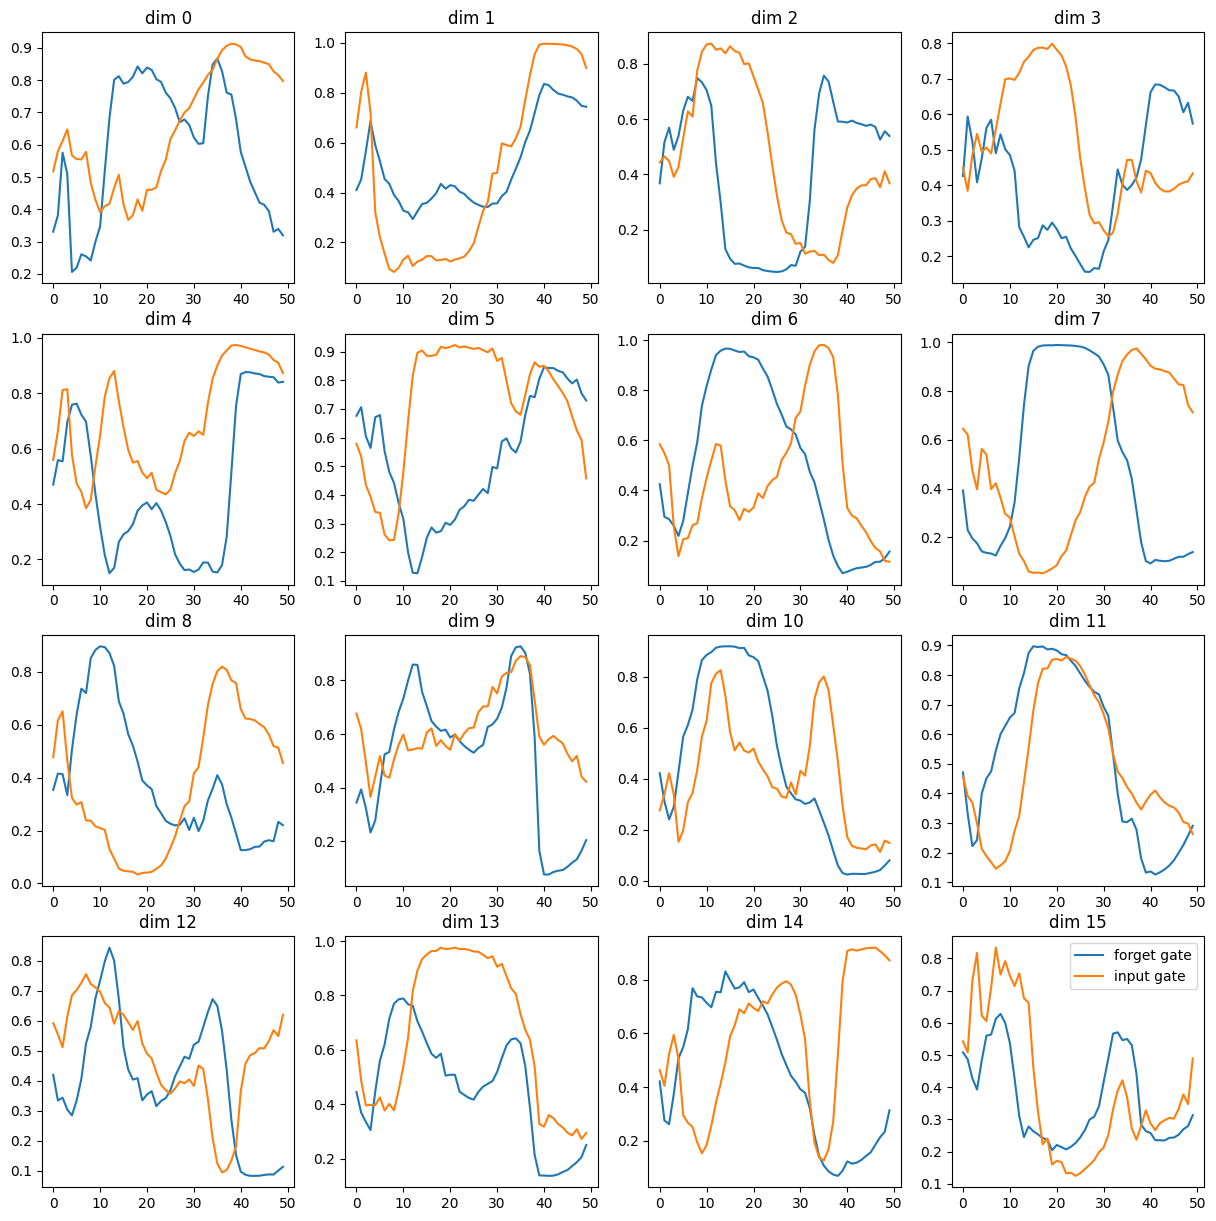

In [20]:
fig, ax = plt.subplots(4,4, figsize=(15,15))

rand_sample = random.randint(0,100)
forget_gate = [[t[rand_sample, d].item() for t in history_lstm["forget"]] for d in range(16)]
input_gate = [[t[rand_sample, d].item() for t in history_lstm["input"]] for d in range(16)]

for i in range(4):
    for j in range(4):
        ax[i,j].plot(forget_gate[4*i+j], label="forget gate")
        ax[i,j].plot(input_gate[4*i+j], label="input gate")
        ax[i,j].set_title(f"dim {4*i+j}")

plt.legend()
plt.show()

# DDPM Training

In [24]:
n_epoch = 5
batch_size = 128
n_T = 1000

In [22]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True,transform=transforms.ToTensor())
ddpm_model = UNET(Channels=[32, 64, 128, 256, 256, 192],          # Much smaller
                  Attentions=[False, True, False, False, True, False], # Keep attention sparse
                  Upscales=[False, False, False, True, True, True],
                  num_groups=8  # Reduce groups since channels are smaller
              ).to(device)

--- Training DDPM on cpu ---


Epoch 1/5: 100%|██████████| 1/1 [00:05<00:00,  5.68s/it]


Epoch 1 | Loss 1.05473


Epoch 2/5: 100%|██████████| 1/1 [00:08<00:00,  8.69s/it]


Epoch 2 | Loss 1.04544


Epoch 3/5: 100%|██████████| 1/1 [00:05<00:00,  5.81s/it]


Epoch 3 | Loss 1.04380


Epoch 4/5: 100%|██████████| 1/1 [00:05<00:00,  5.53s/it]


Epoch 4 | Loss 1.03100


Epoch 5/5: 100%|██████████| 1/1 [00:06<00:00,  6.92s/it]


Epoch 5 | Loss 1.01999


Text(0.5, 0, 'epoch')

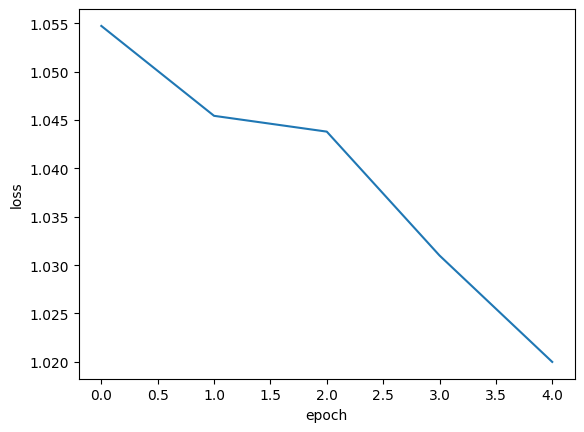

In [25]:
losses = train_ddpm(model=ddpm_model, data=train_dataset, batch_size=batch_size,num_time_steps=n_T, lr=2e-5, num_epochs=n_epoch, device=device, dataset_size=128)

plt.plot(losses)
plt.ylabel("loss")
plt.xlabel("epoch")

In [ ]:
history_ddpm = inference(ddpm_model=ddpm_model, checkpoint_path="checkpoints/ddpm_checkpoint", num_time_steps=n_T)

In [75]:
history_ddpm["drift"][0].shape

(1, 1, 32, 32)

# Comparison

In [81]:
def run_rd_exp(model):
    print("=== RD Analysis ===")

    V_view = model.V[1:-1, 1:-1]
    U_view = model.U[1:-1, 1:-1]
    
    # Diffusion Force Magnitude
    lap_V = laplacian(model.V, model.dx)
    force_diff = np.abs(model.D_v * lap_V)
    
    # Reaction Force Magnitude
    uv2 = U_view * V_view**2
    reaction_V = uv2 - (model.F + model.k) * V_view
    force_react = np.abs(reaction_V)
    
    # Metrics: Mean magnitude per cell
    m_diff = np.mean(force_diff)
    m_react = np.mean(force_react)
    
    print(f"RD Diffusion Force: {m_diff:.2e}")
    print(f"RD Reaction Force:  {m_react:.2e}")
    
    return m_diff, m_react

def run_lstm_exp(history):
    print("=== LSTM Analysis ===")

    diff_forces, react_forces = [], []

    for t in range(len(history["input"])):
        i_t = history["input"][t]
        f_t = history["forget"][t]
        C_tilde = history["cell_update"][t]
        C_t = history["cell"][t]
                
        # Reaction (Restoring Force): 
        # The force pushing the state to the new value (oscillation update)
        # Magnitude of new information injected: |i_t * C_tilde|
        f_react = torch.mean(torch.abs(i_t * C_tilde)).item()
        
        # Diffusion (Decay/Stabilization):
        # The force eroding the previous state (forgetting)
        # Magnitude of information removed: |(1 - f_t) * C_prev|
        f_diff = torch.mean(torch.abs((1.0 - f_t) * C_t)).item()
        
        diff_forces.append(f_diff)
        react_forces.append(f_react)
            
    m_diff = np.mean(diff_forces)
    m_react = np.mean(react_forces)

    print(f"LSTM Diffusion Force: {m_diff:.2e}")
    print(f"LSTM Reaction Force:  {m_react:.2e}")
    
    return m_diff, m_react

def run_ddpm_exp(history):
    print("=== DDPM Analysis ===")
    drift_forces = []
    noise_forces = []

    for t in range(len(history_ddpm["time"])):
        drift_vector = torch.tensor(history["drift"][t])
        diffusion_term = torch.tensor(history["diffusion"][t])

        f_react = torch.mean(torch.abs(drift_vector)).item()
        drift_forces.append(f_react)

        f_diff = torch.mean(torch.abs(diffusion_term)).item()
        noise_forces.append(f_diff)

    m_diff = np.mean(noise_forces)
    m_react = np.mean(drift_forces)
    
    print(f"DDPM Noise Force (Diff):  {m_diff:.4f}")
    print(f"DDPM Drift Force (React): {m_react:.4f}")
    
    return m_diff, m_react


In [ ]:
F_list = np.linspace(0.029, 0.0545, 10) # spots to strides
k = 0.062
D_u = 1e-5
D_v = 0.5e-5
T_max = 20000
gs = GrayScott(F=F_list[9], k=k,D_u=D_u, D_v=D_v, N=256)
gs.forward(0,T_max, frame=True, data=False)
rd_diff, rd_react = run_rd_exp(gs)

F=0.054, k=0.062: 100%|█████████████████████████████████████▉| 16380/16384 [00:30<00:00, 545.19it/s]


=== RD Analyzis ===
RD Diffusion Force: 3.22e-03
RD Reaction Force:  3.22e-03


In [67]:
rand_index = random.randint(0, n_samples)
seed_sample = lstm_data[rand_index]
generated, history_lstm_gen = lstm_model.generate_sequence(seed_sample, future_steps=future_steps)
lstm_diff, lstm_react = run_lstm_exp(history_lstm_gen)

LSTM Diffusion Force: 2.94e-01
LSTM Reaction Force:  3.38e-01


Starting inference on cpu with 1000 steps...


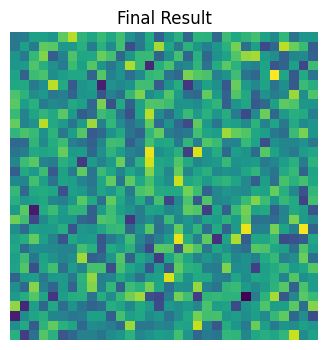

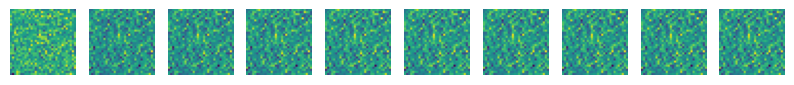

=== DDPM Analysis ===
DDPM Noise Force (Diff):  0.0756
DDPM Drift Force (React): 0.2181


In [84]:
history_ddpm = inference(ddpm_model=ddpm_model, checkpoint_path="checkpoints/ddpm_checkpoint", num_time_steps=n_T)
ddpm_diff, ddpm_react = run_ddpm_exp(history_ddpm)

In [87]:
# Calculate Ratios
rd_ratio = rd_react / (rd_diff + 1e-10)
lstm_ratio = lstm_react / (lstm_diff + 1e-10)
ddpm_ratio = ddpm_react / (ddpm_diff + 1e-10)

print(f"{'Model':<20} | {'M_diff (Decay)':<18} | {'M_react (Growth)':<18} | {'Ratio (R)':<15}")
print("-" * 80)
print(f"{'Gray-Scott (RD)':<20} | {rd_diff:<18.2e} | {rd_react:<18.2e} | {rd_ratio:<15.4f}")
print(f"{'LSTM':<20} | {lstm_diff:<18.2e} | {lstm_react:<18.2e} | {lstm_ratio:<15.4f}")
print(f"{'DDPM':<20} | {ddpm_diff:<18.2e} | {ddpm_react:<18.2e} | {ddpm_ratio:<15.4f}")

Model                | M_diff (Decay)     | M_react (Growth)   | Ratio (R)      
--------------------------------------------------------------------------------
Gray-Scott (RD)      | 3.22e-03           | 3.22e-03           | 1.0000         
LSTM                 | 2.94e-01           | 3.38e-01           | 1.1496         
DDPM                 | 7.56e-02           | 2.18e-01           | 2.8862         


In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

from grayscott import GrayScott, laplacian
from lstm import LSTMCell
from ddpm import UNET, DDPM_Scheduler

def run_rd_forces():
    print("\n--- Starting RD Force Analysis ---")
    
    # Parameters for "Spot" regime
    F = 0.0545
    k = 0.062
    D_u = 1e-5
    D_v = 0.5e-5
    
    gs = GrayScott(F=F, k=k, D_u=D_u, D_v=D_v, N=100)
    
    # We need to run step() manually to capture the *forces* inside the equation
    # u_new = u + dt * (Diffusion_Term + Reaction_Term)
    
    T_steps = 20000
    react_forces = []
    diff_forces = []
    
    # Run loop
    for _ in range(T_steps):
        # Extract current state views (excluding boundaries for calculation)
        U_view = gs.U[1:-1, 1:-1]
        V_view = gs.V[1:-1, 1:-1]
        
        # Calculate Laplacian (Diffusion Force)
        # Note: laplacian() returns just the spatial derivative part
        # Force = D_u * laplacian
        lap_u = laplacian(gs.U, gs.dx)
        diffusion_force_u = gs.D_u * lap_u
        
        # Calculate Reaction (Reaction Force)
        # Force = -uv^2 + F(1-u)
        uv2 = U_view * V_view**2
        reaction_force_u = -uv2 + gs.F * (1.0 - U_view)
        
        # Store mean absolute magnitudes
        # We focus on U (activator) dynamics as the primary structure builder
        diff_forces.append(np.mean(np.abs(diffusion_force_u)))
        react_forces.append(np.mean(np.abs(reaction_force_u)))
        
        # Actual Update
        gs.step()

    m_diff = np.mean(diff_forces)
    m_react = np.mean(react_forces)
    
    print(f"RD Diffusion Force: {m_diff:.2e}")
    print(f"RD Reaction Force:  {m_react:.2e}")
    
    return m_diff, m_react

# ==========================================
# 2. LSTM - Force Analysis
# ==========================================
def run_lstm_forces():
    print("\n--- Starting LSTM Force Analysis ---")
    
    seq_length = 100
    hidden_size = 64
    input_size = 1
    batch_size = 32
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    cell = LSTMCell(input_size, hidden_size).to(device)
    # No training needed for architectural dynamics analysis, 
    # but weights should be initialized (randomly) to non-zero values.
    
    # Data: Random noise to simulate active processing
    x = torch.randn(batch_size, seq_length, input_size).to(device)
    h = torch.zeros(batch_size, hidden_size).to(device)
    c = torch.zeros(batch_size, hidden_size).to(device)
    
    react_magnitudes = []
    diff_magnitudes = []
    
    with torch.no_grad():
        for t in range(seq_length):
            x_t = x[:, t, :]
            
            # We need to access the gates, so we use the cell logic manually 
            # or rely on the fact that your LSTMCell returns 'dynamics'
            h_next, c_next, dynamics = cell(x_t, h, c)
            
            # Extract Gates
            i_t = dynamics["input"]       # Input Gate
            f_t = dynamics["forget"]      # Forget Gate
            C_tilde = dynamics["cell_update"] # Candidate Cell
            
            # 1. Reaction Force (Input Update)
            # The term adding new information: i_t * C_tilde
            input_update = i_t * C_tilde
            react_mag = torch.mean(torch.abs(input_update)).item()
            
            # 2. Diffusion Force (State Decay)
            # The term representing information loss: c_{t-1} - (f_t * c_{t-1})
            # Which simplifies to: (1 - f_t) * c_{t-1}
            decay_force = (1.0 - f_t) * c
            diff_mag = torch.mean(torch.abs(decay_force)).item()
            
            react_magnitudes.append(react_mag)
            diff_magnitudes.append(diff_mag)
            
            h, c = h_next, c_next

    m_diff = np.mean(diff_magnitudes)
    m_react = np.mean(react_magnitudes)
    
    print(f"LSTM Decay Force (Diff):   {m_diff:.4f}")
    print(f"LSTM Input Force (React):  {m_react:.4f}")
    
    return m_diff, m_react

# ==========================================
# 3. DDPM - Force Analysis
# ==========================================
def run_ddpm_forces():
    print("\n--- Starting DDPM Force Analysis ---")
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_time_steps = 1000
    img_size = 32
    
    model = UNET(output_channels=1, input_channels=1, time_steps=num_time_steps).to(device)
    scheduler = DDPM_Scheduler(num_time_steps=num_time_steps)
    model.eval()
    
    z = torch.randn(1, 1, img_size, img_size).to(device)
    
    drift_forces = []
    noise_forces = []
    
    print("Running Inference...")
    with torch.no_grad():
        for t in reversed(range(1, num_time_steps)):
            t_tensor = torch.tensor([t], device=device)
            t_list = [t]
            
            # Predict Noise
            pred_noise = model(z, t_tensor)
            
            # Get Params
            beta_t = scheduler.beta[t_list]
            alpha_bar_t = scheduler.alpha[t_list]
            alpha_t = 1 - beta_t
            
            # 1. Calculate Drift Force (Reaction)
            # The deterministic update step (moving towards structure)
            # Formula: mean = 1/sqrt(alpha) * (z - beta/sqrt(1-alpha_bar) * pred_noise)
            # The "Force" is the change vector: mean - z
            term2 = beta_t / (torch.sqrt(1 - alpha_bar_t) * torch.sqrt(alpha_t))
            # Simplified proxy for the drift update vector magnitude:
            drift_vector = -term2 * pred_noise.cpu() 
            # Note: There is also a scaling factor 1/sqrt(alpha) on z, 
            # but the primary "direction" comes from pred_noise.
            
            m_react = torch.mean(torch.abs(drift_vector)).item()
            drift_forces.append(m_react)
            
            # 2. Calculate Diffusion Force (Noise)
            noise = torch.randn_like(z)
            sigma = torch.sqrt(beta_t)
            diffusion_term = sigma * noise
            
            m_diff = torch.mean(torch.abs(diffusion_term)).item()
            noise_forces.append(m_diff)
            
            # Update
            # Simplified update for measurement (ignoring exact coeff for z)
            z = z + drift_vector.to(device) + diffusion_term.to(device)

    m_diff = np.mean(noise_forces)
    m_react = np.mean(drift_forces)
    
    print(f"DDPM Noise Force (Diff):  {m_diff:.4f}")
    print(f"DDPM Drift Force (React): {m_react:.4f}")
    
    return m_diff, m_react

In [36]:
rd_diff, rd_react = run_rd_forces()
lstm_diff, lstm_react = run_lstm_forces()
ddpm_diff, ddpm_react = run_ddpm_forces()

# Calculate Ratios
rd_ratio = rd_react / (rd_diff + 1e-10)
lstm_ratio = lstm_react / (lstm_diff + 1e-10)
ddpm_ratio = ddpm_react / (ddpm_diff + 1e-10)

print("\n\n==================================================")
print("CORRECTED RESULTS: DYNAMIC FORCE ANALYSIS")
print("==================================================")
print(f"{'Model':<20} | {'Force_Diff':<15} | {'Force_React':<15} | {'Ratio (R)':<15}")
print("-" * 75)
print(f"{'Gray-Scott (RD)':<20} | {rd_diff:<15.2e} | {rd_react:<15.2e} | {rd_ratio:<15.4f}")
print(f"{'LSTM':<20} | {lstm_diff:<15.4f} | {lstm_react:<15.4f} | {lstm_ratio:<15.4f}")
print(f"{'DDPM':<20} | {ddpm_diff:<15.4f} | {ddpm_react:<15.4f} | {ddpm_ratio:<15.4f}")
print("==================================================")


--- Starting RD Force Analysis ---
RD Diffusion Force: 5.56e-03
RD Reaction Force:  5.55e-03

--- Starting LSTM Force Analysis ---
LSTM Decay Force (Diff):   0.3037
LSTM Input Force (React):  0.4097

--- Starting DDPM Force Analysis ---
Running Inference...
DDPM Noise Force (Diff):  0.0757
DDPM Drift Force (React): 0.0022


CORRECTED RESULTS: DYNAMIC FORCE ANALYSIS
Model                | Force_Diff      | Force_React     | Ratio (R)      
---------------------------------------------------------------------------
Gray-Scott (RD)      | 5.56e-03        | 5.55e-03        | 0.9991         
LSTM                 | 0.3037          | 0.4097          | 1.3492         
DDPM                 | 0.0757          | 0.0022          | 0.0288         


In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Import your existing modules
from grayscott import GrayScott, laplacian
from lstm import LSTMCell
from ddpm import UNET, DDPM_Scheduler

def run_rd_force_experiment():
    print("\n--- Starting Reaction-Diffusion Force Analysis ---")
    F, k = 0.0545, 0.062
    D_u, D_v = 1e-5, 0.5e-5
    gs = GrayScott(F=F, k=k, D_u=D_u, D_v=D_v, N=100)
    
    # Run to stable state
    gs.forward(0, 1000, frame=False, data=False)
    
    # Calculate Forces on the Inhibitor (V)
    # Equation: dV/dt = Dv*Laplacian(V) + (uv^2 - (F+k)V)
    # Term 1: Diffusion Force (Spreading/Smoothing)
    # Term 2: Reaction Force (Growth/Decay)
    
    V_view = gs.V[1:-1, 1:-1]
    U_view = gs.U[1:-1, 1:-1]
    
    # Diffusion Force Magnitude
    lap_V = laplacian(gs.V, gs.dx)
    force_diff = np.abs(gs.D_v * lap_V)
    
    # Reaction Force Magnitude
    uv2 = U_view * V_view**2
    reaction_V = uv2 - (gs.F + gs.k) * V_view
    force_react = np.abs(reaction_V)
    
    # Metrics: Mean magnitude per cell
    m_diff = np.mean(force_diff)
    m_react = np.mean(force_react)
    
    print(f"RD Diffusion Force: {m_diff:.2e}")
    print(f"RD Reaction Force:  {m_react:.2e}")
    
    return m_diff, m_react

def run_lstm_force_experiment():
    print("\n--- Starting LSTM Force Analysis ---")
    hidden_size = 16
    input_size = 1
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Initialize Cell
    cell = LSTMCell(input_size, hidden_size).to(device)
    
    # Generate random sequence
    x = torch.randn(32, 100, input_size).to(device)
    h = torch.zeros(32, hidden_size).to(device)
    c = torch.zeros(32, hidden_size).to(device)
    
    diff_forces = []
    react_forces = []
    
    with torch.no_grad():
        for t in range(100):
            c_prev = c.clone()
            
            # Forward step
            x_t = x[:, t, :]
            h, c, dynamics = cell(x_t, h, c)
            
            # LSTM Equation: C_t = f_t * C_prev + i_t * C_tilde
            # Rearranged: delta_C = (f_t - 1)*C_prev + i_t * C_tilde
            # Term 1: Decay/Diffusion Force (Information Loss)
            # Term 2: Reaction Force (Information Gain)
            
            f_t = dynamics["forget"]
            i_t = dynamics["input"]
            c_tilde = dynamics["cell_update"]
            
            # Force 1: Decay (How much did we suppress the past?)
            # Magnitude of (f_t - 1) * C_prev
            force_decay = torch.abs((f_t - 1.0) * c_prev).mean().item()
            
            # Force 2: Input (How much did we add?)
            # Magnitude of i_t * c_tilde
            force_input = torch.abs(i_t * c_tilde).mean().item()
            
            diff_forces.append(force_decay)
            react_forces.append(force_input)
            
    m_diff = np.mean(diff_forces)
    m_react = np.mean(react_forces)
    
    print(f"LSTM Decay Force (Diff): {m_diff:.2e}")
    print(f"LSTM Input Force (React): {m_react:.2e}")
    
    return m_diff, m_react

def run_ddpm_force_experiment():
    print("\n--- Starting DDPM Force Analysis ---")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = UNET(time_steps=1000).to(device)
    scheduler = DDPM_Scheduler(num_time_steps=1000)
    model.eval()
    
    z = torch.randn(1, 1, 32, 32).to(device)
    
    drift_forces = []
    diffusion_forces = []
    
    # Sample a few steps to get the average forces
    # We don't need the full loop to diverge, just the magnitudes
    with torch.no_grad():
        for t in reversed(range(1, 1000, 10)): # Subsample for speed
            t_tensor = torch.tensor([t], device=device)
            
            # 1. Predict Noise / Drift
            pred_noise = model(z, t_tensor)
            
            # 2. Get coeffs
            beta_t = scheduler.beta[t]
            alpha_bar_t = scheduler.alpha[t]
            alpha_t = 1 - beta_t
            
            # 3. Calculate Deterministic Drift Force (The update vector)
            # mean_update = (1/sqrt(alpha)) * (z - coeff * pred_noise) - z
            # Simplification: The "Force" driving it to the manifold is the predicted noise part scaled
            coeff = beta_t / (torch.sqrt(1 - alpha_bar_t) * torch.sqrt(alpha_t))
            drift_force = torch.abs(coeff * pred_noise).mean().item()
            
            # 4. Calculate Stochastic Diffusion Force
            sigma = torch.sqrt(beta_t)
            noise = torch.randn_like(z)
            diffusion_force = torch.abs(sigma * noise).mean().item()
            
            drift_forces.append(drift_force)
            diffusion_forces.append(diffusion_force)
            
            # Update z (dummy update to keep scale correct)
            z = (z - coeff * pred_noise) / torch.sqrt(alpha_t) + sigma * noise
            
    m_diff = np.mean(diffusion_forces)
    m_react = np.mean(drift_forces)
    
    print(f"DDPM Diffusion Force: {m_diff:.2e}")
    print(f"DDPM Drift Force:     {m_react:.2e}")
    
    return m_diff, m_react

In [38]:
print("=== COMPARATIVE FORCE ANALYSIS ===")

rd_diff, rd_react = run_rd_force_experiment()
lstm_diff, lstm_react = run_lstm_force_experiment()
ddpm_diff, ddpm_react = run_ddpm_force_experiment()

# Calculate Ratios
rd_ratio = rd_react / (rd_diff + 1e-10)
lstm_ratio = lstm_react / (lstm_diff + 1e-10)
ddpm_ratio = ddpm_react / (ddpm_diff + 1e-10)

print("\n\n=== FINAL RESULTS: DYNAMIC FORCE RATIOS ===")
print(f"{'Model':<20} | {'M_diff (Decay)':<18} | {'M_react (Growth)':<18} | {'Ratio (R)':<15}")
print("-" * 80)
print(f"{'Gray-Scott (RD)':<20} | {rd_diff:<18.2e} | {rd_react:<18.2e} | {rd_ratio:<15.4f}")
print(f"{'LSTM':<20} | {lstm_diff:<18.2e} | {lstm_react:<18.2e} | {lstm_ratio:<15.4f}")
print(f"{'DDPM':<20} | {ddpm_diff:<18.2e} | {ddpm_react:<18.2e} | {ddpm_ratio:<15.4f}")

=== COMPARATIVE FORCE ANALYSIS ===

--- Starting Reaction-Diffusion Force Analysis ---


F=0.054, k=0.062:  96%|███████████████████████████████████████▎ | 120/125 [00:00<00:00, 2724.58it/s]


RD Diffusion Force: 2.19e-05
RD Reaction Force:  2.56e-05

--- Starting LSTM Force Analysis ---
LSTM Decay Force (Diff): 2.45e-01
LSTM Input Force (React): 3.27e-01

--- Starting DDPM Force Analysis ---
DDPM Diffusion Force: 7.54e-02
DDPM Drift Force:     1.44e-03


=== FINAL RESULTS: DYNAMIC FORCE RATIOS ===
Model                | M_diff (Decay)     | M_react (Growth)   | Ratio (R)      
--------------------------------------------------------------------------------
Gray-Scott (RD)      | 2.19e-05           | 2.56e-05           | 1.1697         
LSTM                 | 2.45e-01           | 3.27e-01           | 1.3370         
DDPM                 | 7.54e-02           | 1.44e-03           | 0.0191         


In [ ]:
# 1. Get Gray Scott Data
# gs is your GrayScott instance
# gs_history should be a list of frames you saved during the loop
gs = GrayScott(F=F_DEFAULT, k=k_DEFAULT, D_u=Du_DEFAULT, D_v=Dv_DEFAULT, x0=x0, x1=x1, N=N)
_, V_final, V_history, _, _ = gs.forward(0, 5000, frame=False, data=False)
gs_final = V_final[1:-1, 1:-1]
gs_history = np.array(V_history) # Shape: [Time, H, W]

# 2. Get LSTM Data
# output is the predicted sequence [Batch, Seq, 1]
lstm = LSTM().to(device)
lstm_output, _ = lstm.forward(lstm_data)
lstm_final = lstm_output[0, :, 0].to("cpy").detach().numpy()
lstm_history = lstm_output[0, :, :].to("cpu").detach().numpy() # Treat sequence as history

# 3. Get DDPM Data
# final_img is [1, 28, 28]
# history is list of arrays [Time, 1, 28, 28]
ddpm_final_img, ddpm_history_list = ddpm_model.sample(1,)
ddpm_final = ddpm_final_img.squeeze().cpu().numpy()
ddpm_history = np.array([x.squeeze() for x in ddpm_history_list])

# 4. Run Comparison
analyzer = Analyzer()
analyzer.compare_models(gs_final, gs_history, 
                        lstm_final, lstm_history, 
                        ddpm_final, ddpm_history)

F=0.054, k=0.062: 100%|███████████████████████████████████████▉| 8190/8192 [00:13<00:00, 593.99it/s]
